In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -U imbalanced-learn

     |████████████████████████████████| 174kB 9.4MB/s 
     |████████████████████████████████| 6.8MB 19.3MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [3]:
import pandas as pd
note = pd.read_csv("/content/drive/My Drive/keep_last_note_train.csv")
note_content = list(note['note'])
note_label = list(note['label'])


In [4]:
import gensim
token_sentences = [s.lower().split() for s in note_content]
model = gensim.models.Word2Vec(sentences=token_sentences, min_count=1)

In [5]:


import nltk
nltk.download('stopwords')
nltk.download('wordnet')
  
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
  
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
tf.executing_eagerly()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [8]:
from sklearn.model_selection import train_test_split, StratifiedKFold
words = model.wv.vocab
MAX_FEATURES = len(words)
EMBED_SIZE = 128
x_train, x_test, y_train, y_test = train_test_split(note_content, note_label, test_size=0.25, random_state=1000)

In [9]:

tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(x_train)
X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
print(X_train.shape)

(16541, 100)


In [10]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where
counter = Counter(y_train)
print(counter)
oversample = SMOTE()
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
# summarize the new class distribution
counter = Counter(y_train_over)
print(counter)

Counter({0: 15064, 1: 1477})
Counter({1: 15064, 0: 15064})


In [11]:
BUFFER_SIZE = len(X_train_over)
BATCH_SIZE = 64
steps_per_epoch = len(X_train_over)//BATCH_SIZE
embedding_dim = 256
units = 1024


train_dataset = tf.data.Dataset.from_tensor_slices((X_train_over, y_train_over)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
print(test_dataset)

<BatchDataset shapes: ((64, 100), (64,)), types: (tf.int32, tf.int32)>


In [12]:
example_input_batch, example_label_batch = next(iter(train_dataset))
example_test_batch, example_test_label = next(iter(test_dataset))


In [13]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

vocab_inp_size = len(words)
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 100, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [14]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [15]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))


Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 100, 1)


In [16]:
class Out(tf.keras.Model):
  def __init__(self, dec_units):
    super(Out, self).__init__()
    self.dec_units = dec_units
    self.attention = BahdanauAttention(self.dec_units)
    self.fc = tf.keras.layers.Dense(1, activation='sigmoid')
  
  def call(self, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    #d = self.dense(context_vector)
    x = self.fc(context_vector)
    return x, attention_weights

decoder = Out(units)
#print(tf.random.uniform((BATCH_SIZE, 1)))
e = tf.reshape(example_label_batch, [BATCH_SIZE,1])
sample_decoder_output, _ = decoder(sample_hidden, sample_output)

print ('output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

output shape: (batch_size, vocab size) (64, 1)


In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss_object = tf.keras.losses.BinaryCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

loss_function(e, sample_decoder_output)


<tf.Tensor: shape=(), dtype=float32, numpy=0.36202863>

In [ ]:
import time
import os
checkpoint_dir = "/content/drive/My Drive/training_checkpoints_4"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
train_auc_metric = tf.keras.metrics.AUC()
all_target = []
all_pred = []
previous_auc = 0
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = targ

   
    predictions, dec_hidden = decoder(dec_hidden, enc_output)

    loss += loss_function(targ, predictions)
      

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))
  

  return batch_loss, predictions

EPOCHS = 3
f = open('train_prediction_target.txt', 'w')
for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
    f.write('batch ' + str(batch) + '\n')
    targ_train = tf.reshape(targ, [BATCH_SIZE,1])
    f.write(str(targ) + '\n')
    batch_loss, predictions = train_step(inp, targ_train, enc_hidden)
    predictions_w = tf.reshape(predictions, [1, BATCH_SIZE])
    f.write(str(predictions_w) + '\n')
    total_loss += batch_loss
    train_acc_metric.update_state(targ_train, predictions)
    train_auc_metric.update_state(targ_train, predictions)
    predictions = tf.reshape(predictions, [1, BATCH_SIZE])
    all_target.append(targ.numpy())
    all_pred.append(predictions.numpy())
    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
    train_acc = train_acc_metric.result()
    train_auc = train_auc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))
    print("Training auc over epoch: %.4f" % (float(train_auc),))
    if train_auc > previous_auc and abs(train_auc - train_acc) < 0.1:
      checkpoint.save(file_prefix = checkpoint_prefix)
      previous_auc = train_auc
    train_acc_metric.reset_states()
    train_auc_metric.reset_states()
  # saving (checkpoint) the model every 2 epochs


  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
f.close()

Epoch 1 Batch 0 Loss 0.3304
Training acc over epoch: 0.6094
Training auc over epoch: 0.5000
Training acc over epoch: 0.5312
Training auc over epoch: 0.6941
Training acc over epoch: 0.4688
Training auc over epoch: 0.5000
Training acc over epoch: 0.5625
Training auc over epoch: 0.5694
Training acc over epoch: 0.5625
Training auc over epoch: 0.9008
Training acc over epoch: 0.4219
Training auc over epoch: 0.5270
Training acc over epoch: 0.5781
Training auc over epoch: 0.7518
Training acc over epoch: 0.5312
Training auc over epoch: 0.8373
Training acc over epoch: 0.5312
Training auc over epoch: 0.7324
Training acc over epoch: 0.4531
Training auc over epoch: 0.9315
Training acc over epoch: 0.4375
Training auc over epoch: 0.9072
Training acc over epoch: 0.6094
Training auc over epoch: 0.9282
Training acc over epoch: 0.5781
Training auc over epoch: 0.9174
Training acc over epoch: 0.4531
Training auc over epoch: 0.9054
Training acc over epoch: 0.4062
Training auc over epoch: 0.9519
Training acc

In [ ]:
y_train = tf.convert_to_tensor(y_train)
y_train = tf.reshape(y_train, [-1,1])


(16541, 1)
(64, 1)


In [ ]:
inputs = X_test[0]
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print(example_test_batch[0])
def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)
w = sequence_to_text(example_test_batch[0].numpy())
print(w)
inputs = tf.convert_to_tensor(inputs)
print(inputs)

hidden = tf.zeros((64, units))
inputs = tf.reshape(inputs, [-1,1])

output, enc_hidden = encoder(example_test_batch, hidden)
dec_hidden = enc_hidden
dec_input = example_test_label
enc_out = output
dec_input = tf.reshape(dec_input, [BATCH_SIZE,1])
print(dec_hidden.shape, dec_input.shape, enc_out.shape)
predictions, attention_weights = decoder(dec_hidden,
                                                         enc_out)


tf.Tensor(
[  16   19   37   40    6   19   27  359   13   85    9   39  153  936
   75   16   19   37   40    6   19   27  154    9   39   94  922 2943
  754   16   15  152 1475   37 2357   71  152   27  472  110   22   87
   32   99   12  529   83 6041  907   16   19   37   40    6   19   27
  187    7 3367    2 3335  171 4483    6  513   19   37  129    8   19
   27  903  154    9   39   29  619   33   76  384   33  322  651   33
  232 1201  786  226  204 8406  204   33  200  651   33  143  651  304
  143  651], shape=(100,), dtype=int32)
['mg', 'tablet', 'sig', 'one', '1', 'tablet', 'po', 'tid', '3', 'times', 'a', 'day', '23', 'furosemide', '20', 'mg', 'tablet', 'sig', 'one', '1', 'tablet', 'po', 'once', 'a', 'day', '24', 'magnesium', 'hydroxide', '400', 'mg', '5', 'ml', 'suspension', 'sig', 'thirty', '30', 'ml', 'po', 'q6h', 'every', '6', 'hours', 'as', 'needed', 'for', 'constipation', '25', 'naproxen', '250', 'mg', 'tablet', 'sig', 'one', '1', 'tablet', 'po', 'bid', 'with', 'brea

(64, 1)
(64, 100, 1)
(100,)
(100,)
[3.71372494e-07 3.68557295e-07 3.66628853e-07 3.63460174e-07
 4.05824636e-07 4.15262747e-07 4.38553002e-07 4.64943582e-07
 5.07072855e-07 5.62711023e-07 6.84317570e-07 9.02881538e-07
 1.39865165e-06 2.58737282e-06 6.98114081e-06 3.38845966e-05
 2.78729625e-04 2.08518049e-03 6.74235635e-03 1.01754386e-02
 1.18642058e-02 1.21814497e-02 1.23791825e-02 1.22025749e-02
 1.21897003e-02 1.25123020e-02 1.24156568e-02 1.24050099e-02
 1.23561965e-02 1.21538714e-02 1.22462353e-02 1.24397278e-02
 1.24662919e-02 1.24695413e-02 1.24719776e-02 1.23178940e-02
 1.24716628e-02 1.23001775e-02 1.24456696e-02 1.23468218e-02
 1.25222644e-02 1.25193857e-02 1.21924803e-02 1.22344894e-02
 1.20630804e-02 1.22269420e-02 1.23130372e-02 1.23491697e-02
 1.23208743e-02 1.21319005e-02 1.23463469e-02 1.24251926e-02
 1.23468069e-02 1.18592698e-02 1.22289034e-02 1.21928016e-02
 1.23768849e-02 1.20108435e-02 1.21928118e-02 1.22186719e-02
 1.25045618e-02 1.25839207e-02 1.23532675e-02 1.18

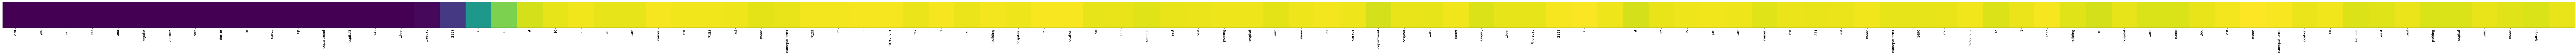

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
print(predictions.shape)
print(attention_weights.shape)
attention_weights_modify = tf.reshape(attention_weights[0], (-1, ))
print(attention_weights_modify.shape)
print(example_test_batch[0].shape)
attention_weights_modify = attention_weights_modify.numpy()
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(200,200))
  ax = fig.add_subplot(1, 1, 1)
  ax.imshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels(sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  #plt.show()
  plt.savefig('test.png')
sentence = example_test_batch[1].numpy()
pred = predictions[1].numpy()
print(attention_weights_modify)
w = sequence_to_text(sentence)
attention_weights_modify = np.expand_dims(attention_weights_modify[:100], axis=0)
print(attention_weights_modify)
print(w[:100])
print(pred)
plot_attention(attention_weights_modify, w[:100], pred)

In [ ]:
steps_per_epoch_test = len(X_test) // BATCH_SIZE
hidden = tf.zeros((64, units))
test_acc_metric = tf.keras.metrics.BinaryAccuracy()
test_auc_metric = tf.keras.metrics.AUC()
result_targ = []
result_pred = []
for (batch, (inp, targ)) in enumerate(test_dataset.take(steps_per_epoch_test)):
  output, enc_hidden = encoder(inp, hidden)
  dec_hidden = enc_hidden
  dec_input = targ
  enc_out = output
  dec_input = tf.reshape(dec_input, [BATCH_SIZE,1])
  predictions,attention_weights = decoder(dec_hidden,
                                                         enc_out)
  test_acc_metric.update_state(dec_input, predictions)
  test_auc_metric.update_state(dec_input, predictions)
  test_acc = test_acc_metric.result()
  test_auc = test_auc_metric.result()
  print("Test acc over epoch: %.4f" % (float(test_acc),))
  print("Test auc over epoch: %.4f" % (float(test_auc),))
  test_acc_metric.reset_states()
  test_auc_metric.reset_states()
  out_pred = tf.reshape(predictions, [1, BATCH_SIZE])
  result_targ.append(targ.numpy())
  result_pred.append(out_pred.numpy()[0])


Test acc over epoch: 0.5469
Test auc over epoch: 0.5259
Test acc over epoch: 0.6406
Test auc over epoch: 0.8083
Test acc over epoch: 0.5938
Test auc over epoch: 0.7797
Test acc over epoch: 0.6875
Test auc over epoch: 0.8361
Test acc over epoch: 0.5938
Test auc over epoch: 0.7719
Test acc over epoch: 0.5625
Test auc over epoch: 0.7586
Test acc over epoch: 0.6094
Test auc over epoch: 0.7917
Test acc over epoch: 0.6250
Test auc over epoch: 0.7051
Test acc over epoch: 0.7188
Test auc over epoch: 0.4814
Test acc over epoch: 0.5781
Test auc over epoch: 0.7005
Test acc over epoch: 0.6719
Test auc over epoch: 0.5475
Test acc over epoch: 0.6094
Test auc over epoch: 0.6554
Test acc over epoch: 0.6875
Test auc over epoch: 0.7390
Test acc over epoch: 0.6094
Test auc over epoch: 0.6750
Test acc over epoch: 0.5938
Test auc over epoch: 0.7011
Test acc over epoch: 0.6250
Test auc over epoch: 0.5690
Test acc over epoch: 0.5312
Test auc over epoch: 0.7619
Test acc over epoch: 0.6094
Test auc over epoch:

64


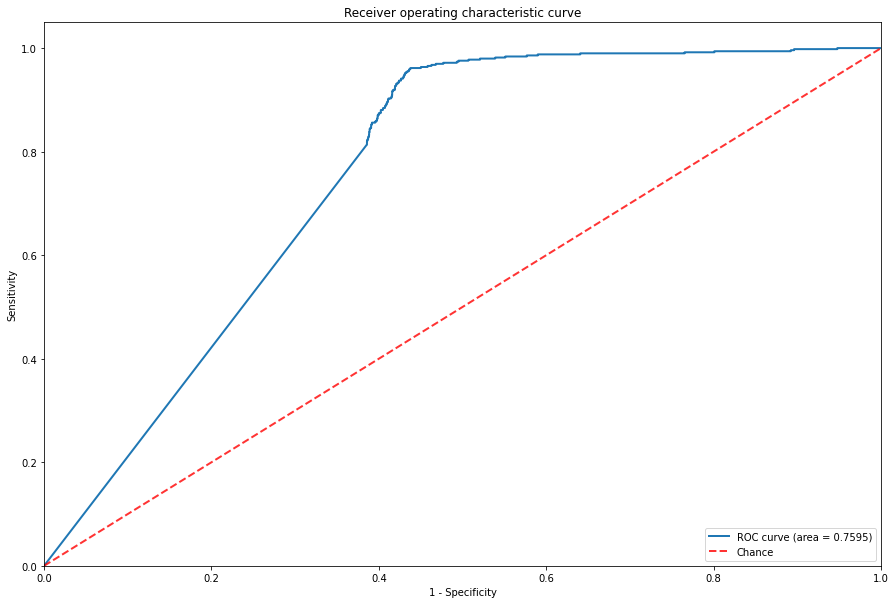

tf.Tensor(0.6322674, shape=(), dtype=float32)


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
def plot_roc_curve(ground_truth, predictions, filename=None):
    fpr, tpr, thr = roc_curve(y_true=ground_truth, y_score=predictions, drop_intermediate=False)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(15,10))
    lw = 2
    plt.plot(fpr, tpr,
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    if filename:
        plt.savefig(filename, dpi=500)
    plt.show()
    return fpr, tpr

print(len(result_targ[0]))
targ = []
pred = []
for t in result_targ:
  targ.extend(t)
for p in result_pred:
  pred.extend(p)

test_fpr, test_tpr = plot_roc_curve(targ, pred)
test_acc_ = tf.keras.metrics.BinaryAccuracy()
test_acc_.update_state(targ, pred)
print(test_acc_.result())

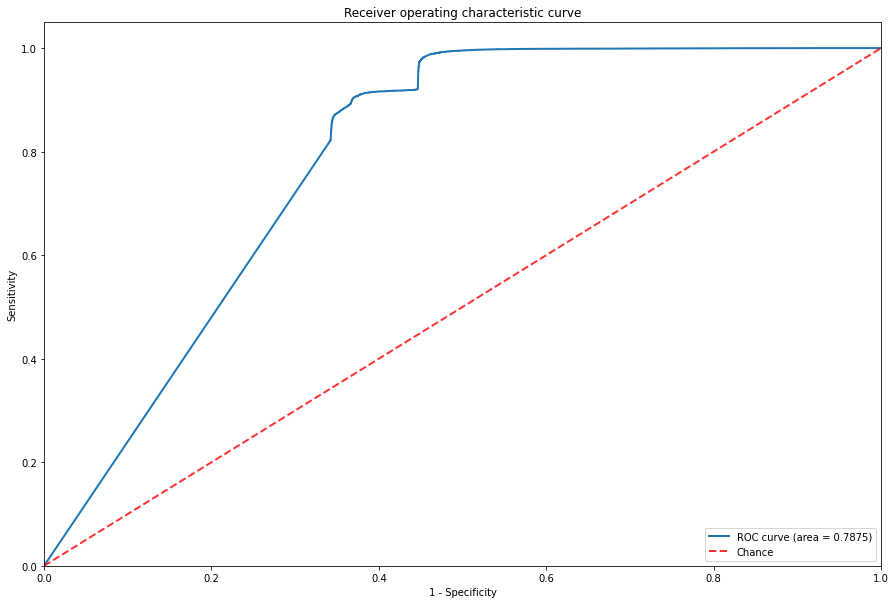

tf.Tensor(0.76192373, shape=(), dtype=float32)


In [ ]:
train_all_targ = []
train_all_pred = []
for t in all_target:
  train_all_targ.extend(t)
for p in all_pred:
  temp = p.tolist()
  #print(temp)
  train_all_pred.extend(temp[0])

plot_roc_curve(train_all_targ, train_all_pred)
train_acc_ = tf.keras.metrics.BinaryAccuracy()
train_acc_.update_state(train_all_targ, train_all_pred)
print(train_acc_.result())
